In [30]:
from scipy import integrate
import sympy as sp
import numpy as np
from numba import jit


def arc(t0,arc_length) -> float:
    '''
    输入当前的角度t0和弧长arc_length
    返回前进到的角度t1
    积分是从t1到t0，因为t1的角度更小,前进过程中角度是在减小的
    '''
    distance_value = 170
    c = distance_value / (2 * sp.pi) # 常数 c，用来计算螺线坐标
    a =  0.5 * c * (sp.sqrt(1 + t0**2) * t0 + sp.asinh(t0))
    t1 = sp.symbols('t1') # 定义符号变量t1,设定为未知数
    b =  0.5 * c * (sp.sqrt(1 + t1**2) * t1 + sp.asinh(t1))
    
    equation = a -b - arc_length
    #sp.pprint(equation)
    result = sp.nsolve(equation,t1, t0)
    
    return float(result)

class Queue:
    '''
    实现一个队列，先入先出(FIFO)
    '''
    def __init__(self):
        self.queue = []
    
    def is_empty(self): 
        return len(self.queue) == 0
    
    def push(self, element):
        self.queue.append(element)
    
    def pop(self):
        if self.is_empty():
            return None
        else:
            return self.queue.pop(0)
    
    def get_size(self):
        return len(self.queue)


def search_vertex(head_theta) -> list:
    distance_value = 170
    c = distance_value / (2 * np.pi)  # 常数 c，用来计算螺线坐标
    theta_step = 0.0005     # 角度步长
    vertex = Queue()      # 队列，用于存储待处理的节点
    vertex_list = []      # 存储所有找到的顶点角度
    
    # 初始角度作为第一个顶点
    vertex.push(head_theta)
    vertex_list.append(head_theta)
    while not vertex.is_empty():
        if len(vertex_list) > 223: # 限制最多只能找到 224 个顶点
            #print("找完了",len(vertex_list))
            break
        
        # 从队列中取出当前的角度（作为线段的固定端点）
        current_theta = vertex.pop()
        #print(f"Processing theta: {current_theta}")
        
        # 当前点的坐标
        x0 = c * current_theta * np.cos(current_theta)
        y0 = c * current_theta * np.sin(current_theta)
        
        # 从当前 theta 开始，移动下一个点
        theta = current_theta
        while theta <= 32 * np.pi:
            # 尝试计算下一个点的角度
            next_theta = theta + theta_step
            x1 = c * next_theta * np.cos(next_theta)
            y1 = c * next_theta * np.sin(next_theta)
            
            # 计算两点之间的距离
            distance = np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)
            if distance > 890:
                print(f"Warning!!!!! Distance too large: {distance}")
            
            # 处理距离为 286 的情况，且这是寻找“头部”的条件
            if distance >= 286 and len(vertex_list) == 1:
                #print("ok")
                #print(f"Found head: {next_theta} with distance: {distance}")
                vertex_list.append(next_theta)
                vertex.push(next_theta)  # 将新找到的顶点作为新的固定端点继续搜索
                break  # 找到符合条件的点后跳出当前循环，开始处理下一个顶点
            
            # 处理距离为 165 的情况
            if distance >= 165 and len(vertex_list) > 1 :
                #print(f"Found vertex at theta: {next_theta} with distance: {distance}")
                vertex_list.append(next_theta)
                vertex.push(next_theta)  # 将新找到的顶点作为新的固定端点继续搜索
                break  # 找到符合条件的点后跳出当前循环，开始处理下一个顶点
            
            # 更新 theta，继续向下搜索
            theta += theta_step
    
    return vertex_list

@jit(nopython=True)
def distance(a,b) -> float:
    '''
    输入两个角度a和b
    用近似替代方法计算两点之间的距离
    '''
    distance_value = 170
    c = distance_value / (2 * np.pi)
    
    x0 = c * a * np.cos(a)
    y0 = c * a * np.sin(a)
    x1 = c * b * np.cos(b)
    y1 = c * b * np.sin(b)
    #print("x0,y0,x1,y1",x0,y0,x1,y1)
    return np.sqrt((x1 - x0) ** 2 + (y1 - y0) ** 2)
#distance(32.67299999997398, 33.25299999997675)

def get_speed(t0,time,input_speed) -> list:
    '''
    输入初始角度和运动时间time
    确定时间微元dt为1e-7
    返回进入螺线的所有节点的坐标和速度
    '''
    dt = 1e-7
    distance_value = 170
    
    speed =input_speed
    
    current_arc = time*speed #当前头部的弧长
    updated_arc = (time+dt)*speed #dt时间内头部加上走过的弧长
    
    head_theta = arc(t0,current_arc) #头部当前的角度
    updated_head_theta = arc(t0,updated_arc) #dt后头部的角度
    
    current_theta_list = search_vertex(head_theta)
    #print(current_theta_list)
    after_theta_list = search_vertex(updated_head_theta)  

    
    speed_list = []
    for i in range(len(current_theta_list)):
        a = current_theta_list[i]
        b = after_theta_list[i]
        ds = distance(a,b)
        speed = ds/dt
        speed_list.append(speed)
        
    return current_theta_list,speed_list

@jit(nopython=True)
#求出螺线与掉头空间的两个交点的辐角
def cross_point(radius_value):
    '''
    输入螺线间距值、开始掉头区域的半径值
    输出两个交点的辐角
    '''
    c1 = 170 / (2 * np.pi) #盘入螺线参数
    c2 = -170 / (2 * np.pi) #盘出螺线参数
    
    theta1 = radius_value/c1
    theta2 = radius_value/c2
    return theta1,theta2

def find_minus_100(head_speed,raduis_value):
    '''
    输入头部的速度，单位为cm/s
    找到-100s时刻龙头的位置
    '''
    def arc_back(t0,arc_length) -> float:
        '''
        输入当前的角度t0和弧长arc_length
        用于临时寻找-100s时刻龙头的位置
        '''
        distance_value = -170
        c = distance_value / (2 * sp.pi) # 常数 c，用来计算螺线坐标
        a =  0.5 * c * (sp.sqrt(1 + t0**2) * t0 + sp.asinh(t0))
        t1 = sp.symbols('t1') # 定义符号变量t1,设定为未知数
        b =  0.5 * c * (sp.sqrt(1 + t1**2) * t1 + sp.asinh(t1))
        equation = a -b - arc_length
        result = sp.nsolve(equation,t1, t0)
        return float(result)
    
    head_v = head_speed
    arc_length = 100*head_v
    
    #以交点1为起点
    t0 = cross_point(raduis_value)[0]
    minus_100 = arc_back(t0,arc_length)
    
    return minus_100
    


def search_speed():
    '''
    寻找满足条件的头部速度
    '''
    for i in np.arange(0,100,1):
        input_speed = 100-i
        start = find_minus_100(100,450)
        
        time = 100*100/input_speed
        
        for j in np.arange(1,time):
            print(f"Processing time: {j} of {time} At {input_speed} cm/s")
            max_v = 0
            input_time = j
            _ , all_speed = get_speed(start,input_time,input_speed) 
            current_max_speed = max(all_speed)
            if max_v < current_max_speed:
                max_v = current_max_speed
        print(current_max_speed,input_speed)
        if max(all_speed) <= 200:
            print(f"head speed satifying condition At {input_speed} cm/s")
            return all_speed

search_speed()


Processing time: 1.0 of 100.0 At 100 cm/s
Processing time: 2.0 of 100.0 At 100 cm/s
Processing time: 3.0 of 100.0 At 100 cm/s
Processing time: 4.0 of 100.0 At 100 cm/s
Processing time: 5.0 of 100.0 At 100 cm/s
Processing time: 6.0 of 100.0 At 100 cm/s
Processing time: 7.0 of 100.0 At 100 cm/s
Processing time: 8.0 of 100.0 At 100 cm/s
Processing time: 9.0 of 100.0 At 100 cm/s
Processing time: 10.0 of 100.0 At 100 cm/s
Processing time: 11.0 of 100.0 At 100 cm/s
Processing time: 12.0 of 100.0 At 100 cm/s
Processing time: 13.0 of 100.0 At 100 cm/s
Processing time: 14.0 of 100.0 At 100 cm/s
Processing time: 15.0 of 100.0 At 100 cm/s
Processing time: 16.0 of 100.0 At 100 cm/s
Processing time: 17.0 of 100.0 At 100 cm/s
Processing time: 18.0 of 100.0 At 100 cm/s
Processing time: 19.0 of 100.0 At 100 cm/s
Processing time: 20.0 of 100.0 At 100 cm/s
Processing time: 21.0 of 100.0 At 100 cm/s
Processing time: 22.0 of 100.0 At 100 cm/s
Processing time: 23.0 of 100.0 At 100 cm/s
Processing time: 24.

[60.999979650110525,
 63.27979105368802,
 64.54405339694902,
 65.78481261463297,
 67.00205938309395,
 68.19760110266766,
 69.37324492074833,
 70.52898540611339,
 71.66481726459044,
 72.78436403552178,
 73.88580833588011,
 74.97096043482205,
 76.04163156853753,
 77.09600412485604,
 78.13589081199885,
 79.16310262249927,
 80.17763799542729,
 81.17949501749142,
 82.16867114469727,
 83.14516641033066,
 84.11079240552925,
 85.06554793368474,
 86.00943229358681,
 86.94244393494174,
 87.86639670688103,
 88.7812892640059,
 89.68530598436409,
 90.58026153443674,
 91.46796971048332,
 92.34661445396658,
 93.21619549602514,
 94.07852549103059,
 94.93360774160455,
 95.77962191200285,
 96.61838554557636,
 97.44989728506627,
 98.27415662628951,
 99.09297903403133,
 99.90454582455682,
 100.708861948778,
 101.50773902610308,
 102.29936091387768,
 103.08554362836237,
 103.86628639669429,
 104.63977421096503,
 105.40782250226704,
 106.17042745950577,
 106.9275933206625,
 107.67931825300226,
 108.42560162

In [32]:
import os

with open("q5result.txt",mode="r",encoding="utf-8") as f:
    line = f.readlines()
    prefix_to_delete = "Processing time: "
    
    flitered_lines = [x for x in line if not x.startswith(prefix_to_delete)]

with open ("q5result_final.txt",mode="w",encoding="utf-8") as f:
    f.writelines(flitered_lines)


C:\Users\1\AppData\Local\Temp\ipykernel_34396\1397752480.py:51: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


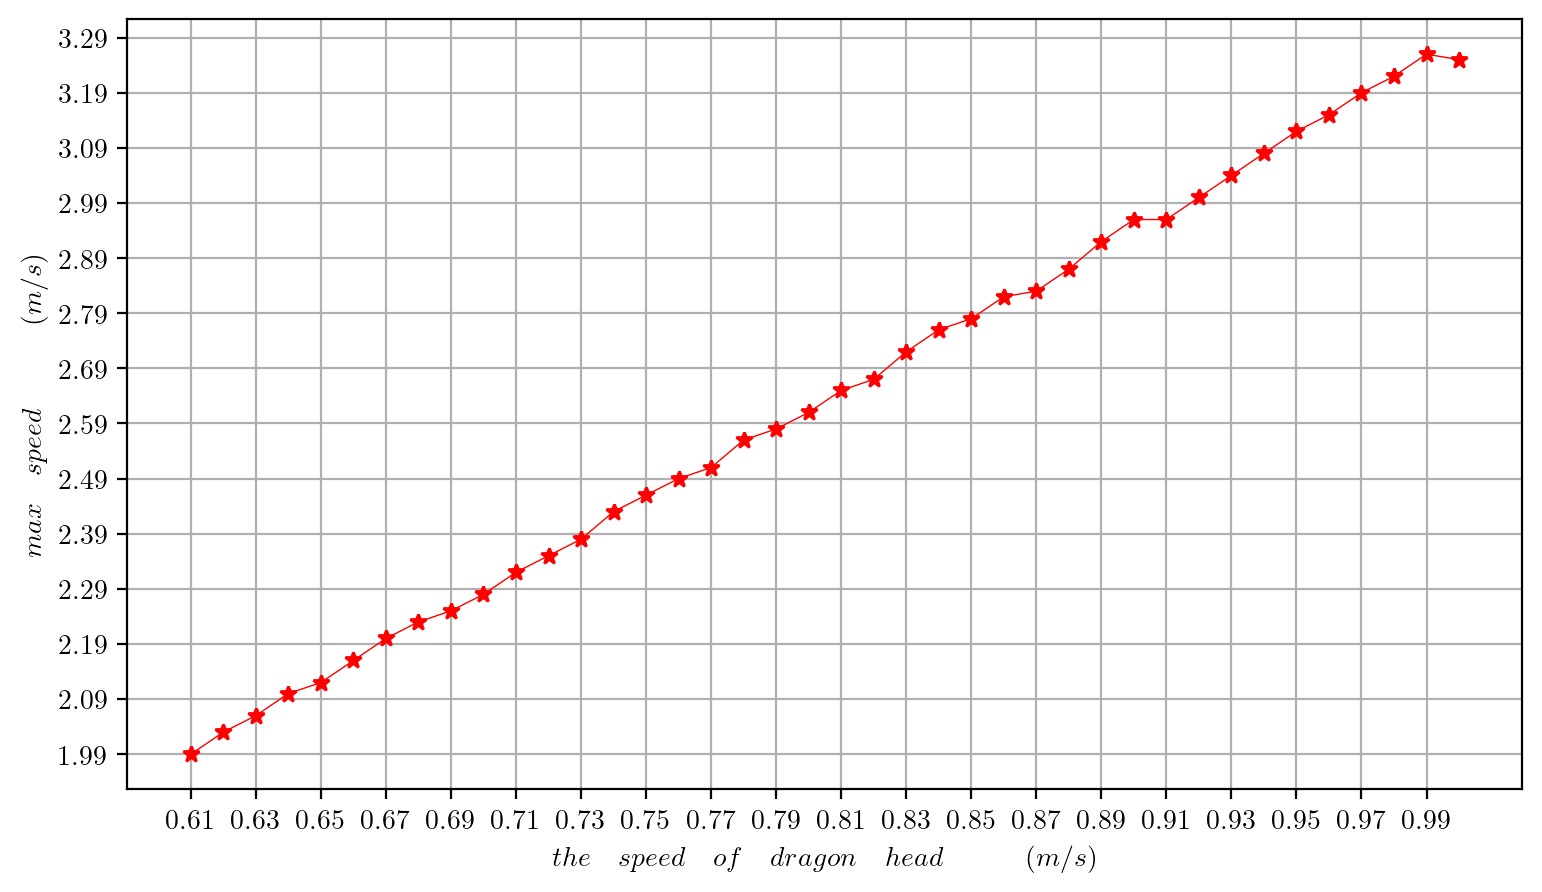

In [2]:
import re
import numpy as np

def get_first_numbers_from_file(filename):
    first_numbers = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # 使用正则表达式匹配行首的数字
            match = re.match(r'\d+', line)
            if match:
                first_numbers.append(int(match.group()))
    return first_numbers

def get_third_numbers_from_file(filename):
    third_numbers = []
    with open(filename, 'r', encoding='utf-8') as file:
        for line in file:
            # 使用正则表达式匹配行中的所有数字
            matches = re.findall(r'\d+', line)
            if len(matches) >= 3:
                third_numbers.append(int(matches[2]))
    return third_numbers

filename = 'q5result_final.txt'
y = get_first_numbers_from_file(filename)
x = get_third_numbers_from_file(filename)
x = [i/100 for i in x]
y = [i/100 for i in y]

from matplotlib import pyplot as plt
'''
画出随着速度减小，板凳龙最大速度节点的变化
'''
plt.rcParams['text.usetex'] = True #设置使用latex渲染
fig , ax1 =  plt.subplots(1,1,figsize=(9,5), dpi=200)


ax1.set_xlabel(r'$the \quad speed \quad of \quad dragon \quad head \quad \quad \quad (m/s)$')
ax1.set_ylabel(r'$max \quad speed \quad \quad \quad (m/s)$')

x_ticks = np.arange(min(x),max(x)+0.01,0.02)
ax1.set_xticks(x_ticks)
y_ticks = np.arange(min(y),max(y)+0.1,0.1)
ax1.set_yticks(y_ticks)

ax1.grid(True)

ax1.plot(x,y,color='r',lw = 0.5,marker='*') 
plt.savefig('plot.svg', format='svg')

fig.show()

